In [1]:
import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



In [8]:
train_dir = "/media/youngwon/Neo/NeoChoi/TIL_Dataset/cityscapes_data/train"
train_fns=os.listdir(train_dir)
train_fns[0]

'1.jpg'

In [9]:
def get_paths_png(paths):
    wav_paths = []
    if type(paths) == str:
        paths = [paths]
    
    # 1. get wav paths
    for path in paths:
        for root, dirs, files in os.walk(path):
            
            wav_paths += [os.path.join(root, file) for file in files if os.path.splitext(file)[-1] == '.jpg']
    
    # 2. sort by filenames
    wav_paths.sort(key = lambda x: os.path.split(x)[-1])

    return wav_paths

(256, 512, 3)

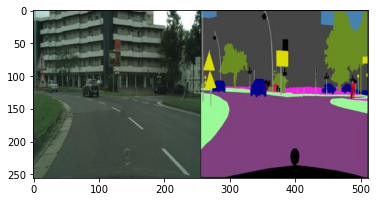

In [10]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
np_image=np.array(sample_image)
np_image.shape


In [11]:
def split_image(image):
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label


In [12]:
cityscape,label=split_image(np_image)

In [16]:
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [17]:
num_classes = 10

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

In [18]:
label_class=label_model.predict(label.reshape(-1, 3)).reshape(256, 256)

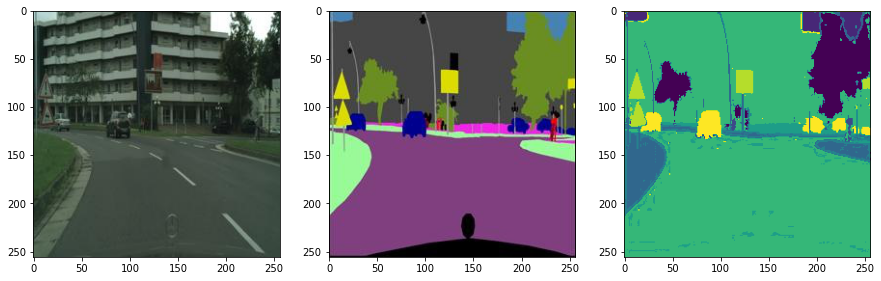

In [19]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [20]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir=image_dir

        color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
        
        self.label_model = KMeans(n_clusters = 10)

        self.label_model.fit(color_array)
        self.paths_jpg=self.get_paths_jpg(self.image_dir)

    def __len__(self) :
        return len(self.paths_jpg)

    def __getitem__(self, index):
        path_jpg=self.paths_jpg[index]
        sample_image = Image.open(path_jpg).convert("RGB")
        np_image=np.array(sample_image)
        cityscape, label= split_image(np_image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        label_class = torch.Tensor(label_class).long()
        cityscape = self.transform(cityscape)
        return cityscape, label_class

    
    def split_image(self,image):
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def get_paths_jpg(self,paths):
        jpg_paths = []
        if type(paths) == str:
            paths = [paths]
    
    
        for path in paths:
            for root, dirs, files in os.walk(path):
            
                jpg_paths += [os.path.join(root, file) for file in files if os.path.splitext(file)[-1] == '.jpg']

        jpg_paths.sort(key = lambda x: os.path.split(x)[-1])

        return jpg_paths

    def transform(self, image) :
        transform_ops = transforms.Compose([
      	    		transforms.ToTensor(),
                    transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
        ])
        return transform_ops(image)   

In [24]:
train=CityscapeDataset("/media/youngwon/Neo/NeoChoi/TIL_Dataset/cityscapes_data/train")
val=CityscapeDataset("/media/youngwon/Neo/NeoChoi/TIL_Dataset/cityscapes_data/val")

In [32]:
a,b=next(iter(train))
